# 이동통신 고객 이탈 예측

* 여러분은 OO 통신화사 데이터분석가 입니다.
* 00 통신회사의 올해 고객 목표는, **현재 고객수를 유지**하는 것입니다.
* 더욱 치열해진 경쟁 상황에서 고객수를 유지하는 것은 굉장히 도전적인 목표 입니다.
* 이를 위해 회사는 약정기간이 끝난 고객이 번호이동(이탈)해 가는 문제를 해결하고자 합니다.
* 그래서 에이블러 여러분에게, 어떤 고객이 번호이동(이탈)해 가는지 예측 모델링을 의뢰하였습니다.

![](https://d18lkz4dllo6v2.cloudfront.net/cumulus_uploads/entry/23964/mobile%20phones.png)

## 0.환경설정

### 1) 라이브러리 로딩

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from scipy import stats as spst

### 2) 데이터 로딩

In [186]:
# mobile data
data_path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_NA2.csv"
data = pd.read_csv(data_path)
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,544,1,47711,183,17,730589.0,192,19,5,unsat,little,considering,0
1,689,0,74132,191,43,535092.0,349,15,2,unsat,very_little,no,1
2,3134,1,150419,0,14,204004.0,682,0,6,unsat,very_high,considering,0
3,12523,0,159567,0,58,281969.0,634,1,1,very_unsat,very_high,never_thought,0
4,2374,1,23392,0,0,216707.0,233,0,15,unsat,very_little,no,1


|변수 명|내용|구분|
|	----	|	----	|	----	|
|	COLLEGE	|	대학졸업 여부(1,0) - 범주	|		|
|	INCOME	|	연 수입액(달러)	|		|
|	OVERAGE	|	월 초과사용 시간(분)	|		|
|	LEFTOVER	|	월 사용 잔여시간비율(%)	|		|
|	HOUSE	|	집 가격(달러)	|		|
|	HANDSET_PRICE	|	핸드폰 가격(달러)	|		|
|	OVER_15MINS_CALLS_PER_MONTH	|	 평균 장기통화(15분 이상) 횟수	|		|
|	AVERAGE_CALL_DURATION	|	평균 통화시간(분)	|		|
|	REPORTED_SATISFACTION	|	만족도 설문('very_unsat', 'unsat', 'avg', 'sat', 'very_sat' ) - 범주	|		|
|	REPORTED_USAGE_LEVEL	|	사용 수준 설문('very_little', 'little', 'avg', 'high', 'very_high') - 범주	|		|
|	CONSIDERING_CHANGE_OF_PLAN	|	변경 계획 설문('never_thought', 'no', 'perhaps', 'considering',   'actively_looking_into_it') - 범주	|		|
|	**CHURN**	|	이탈여부(1 : 이탈, 0 : 잔류)	|	**Target**	|


----

## 1.데이터 탐색

## 2.데이터 전처리 

In [187]:
target = 'CHURN'

### 2.1 데이터 정리

* feature와 , target으로 분할

In [188]:
x = data.drop(target, axis = 1)
y = data.loc[:, target]

* 불필요한 feature 제거
    * 제거해야 할 feature를 선정하고 제거하시오. 제거 이유를 주석으로 기술합니다.

In [189]:
# feature 데이터 확인 
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           18000 non-null  int64  
 1   COLLEGE                      18000 non-null  int64  
 2   INCOME                       18000 non-null  int64  
 3   OVERAGE                      18000 non-null  int64  
 4   LEFTOVER                     18000 non-null  int64  
 5   HOUSE                        17785 non-null  float64
 6   HANDSET_PRICE                18000 non-null  int64  
 7   OVER_15MINS_CALLS_PER_MONTH  18000 non-null  int64  
 8   AVERAGE_CALL_DURATION        18000 non-null  int64  
 9   REPORTED_SATISFACTION        17962 non-null  object 
 10  REPORTED_USAGE_LEVEL         18000 non-null  object 
 11  CONSIDERING_CHANGE_OF_PLAN   18000 non-null  object 
dtypes: float64(1), int64(8), object(3)
memory usage: 1.6+ MB


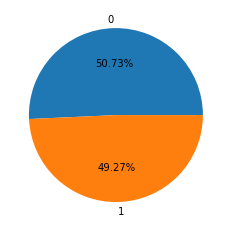

In [190]:
# 이탈여부 분포도 확인
cnt = y.value_counts()
plt.pie(cnt.values, labels = cnt.index, autopct = '%.2f%%')
plt.show()

#### EDA 했던 결과
* 강한 관계
    * OVERAGE
* 중간 관계
    * LEFTOVER, HANDSET_PRICE
* 관계 무
    * REPORTED_SATISFACTION
    * CONSIDERING_CHANGE_OF_PLAN

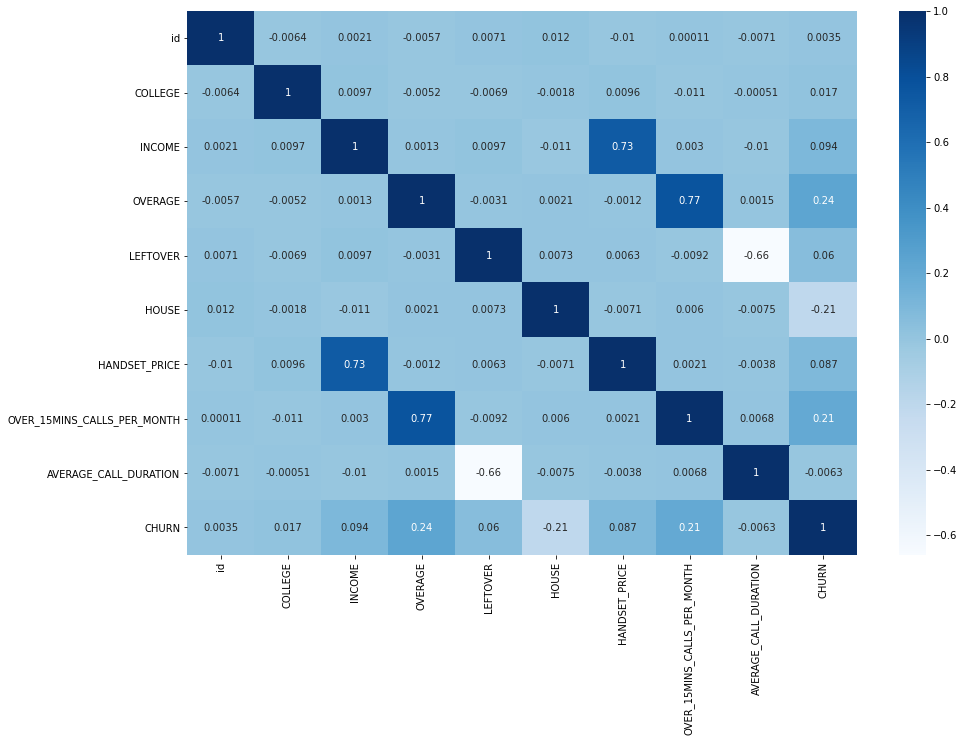

In [191]:
# 상관관계 확인
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True, cmap ='Blues')
plt.show()

In [192]:
# 먼저 집계
table = pd.crosstab(data['REPORTED_USAGE_LEVEL'],data[target])
# 카이제곱검정
result = spst.chi2_contingency(table)
print('카이제곱통계량', result[0])
print('p-value', result[1])
print('자유도', result[2])

카이제곱통계량 0.8977447473626036
p-value 0.9248841494818087
자유도 4


In [193]:
# EDA 와 상관관계를 봤을 때 설문 관련인 REPORTED_SATISFACTION, CONSIDERING_CHANGE_OF_PLAN 은 
# target과 관계가 없음 => 설문조사 내용에 대한 신뢰성이 의심이 된다.
# 카이제곱검정으로 확인 했을 때 REPORTED_USAGE_LEVEL은 target과 관계가 없음 => 이것도 설문조사
# id는 고유한 이름으로써 이탈여부와 관련 짓기가 어렵고 상관관계 또한 매우 낮은 것을 볼 수 있다.

In [194]:
# 불필요한 컬럼 삭제
drop_col = ['id','REPORTED_SATISFACTION', 'CONSIDERING_CHANGE_OF_PLAN', 'REPORTED_USAGE_LEVEL']
x = x.drop(columns= drop_col, axis = 1)

### 2.2 NaN에 대한 조치
* 데이터에 포함된 NaN에 대해서 조치 방법을 결정하고 적용합니다.
* **조치방법을 결정한 이유**를 주석으로 기술합니다.

In [195]:
x.isna().sum()

COLLEGE                          0
INCOME                           0
OVERAGE                          0
LEFTOVER                         0
HOUSE                          215
HANDSET_PRICE                    0
OVER_15MINS_CALLS_PER_MONTH      0
AVERAGE_CALL_DURATION            0
dtype: int64

In [259]:
x[['HOUSE']].describe()

,HOUSE
count,18000.000000
mean,489443.912167
std,252685.429238
min,150015.000000
25%,259092.500000
50%,446412.000000
75%,698473.500000
max,999970.000000


In [196]:
# HOUSE의 결측값은 215개로 소수라고 생각한다. => 18000개의 데이터에서 215개의 결측치
# 그러므로 최빈값으로 결측치를 처리를 하는 것이 가장 안전할 것으로 생각된다.

In [197]:
most = x['HOUSE'].value_counts().idxmax()
x['HOUSE'].fillna(most, inplace=True)

In [198]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   COLLEGE                      18000 non-null  int64  
 1   INCOME                       18000 non-null  int64  
 2   OVERAGE                      18000 non-null  int64  
 3   LEFTOVER                     18000 non-null  int64  
 4   HOUSE                        18000 non-null  float64
 5   HANDSET_PRICE                18000 non-null  int64  
 6   OVER_15MINS_CALLS_PER_MONTH  18000 non-null  int64  
 7   AVERAGE_CALL_DURATION        18000 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 1.1 MB


### 2.3 (옵션) 추가변수 도출
* 기존 데이터셋의 변수를 이용하여 추가로 도출할 수 있는 변수가 있다면 수행합니다.
* 추가변수 생성시, 이유에 대해서 **주석**으로 기술합니다.

In [199]:
# 자산과 관련해서 이탈여부가 있을 것 이라고 생각해서
# 자산과 관련된 연수입, 집값, 핸드폰 가격을 합한 새로운 컬럼을 생성

In [200]:
x['HOUSE_INCOME_HAND'] = x.HOUSE + x.INCOME + x.HANDSET_PRICE

### 2.4 가변수화
* 범주형 데이터이면서 값이 0,1 로 되어 있는 것이 아니라면, 가변수화를 수행해야 합니다.
* 대상이 되는 변수에 대해서 가변수화를 수행해주세요.

In [201]:
# 가변수화 할 컬럼이 없음.

### 2.5 데이터 분할

* test 3000건(test_size = 3000), random_state = 2022
* val 3000건(test_size = 3000), random_state = 2022
* train 나머지.

In [202]:
# 데이터 분할(train - test)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=3000,random_state=2022)

In [203]:
# 데이터 분할(train - val)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=3000, random_state=2022)

### 2.6 (옵션)스케일링 
* 스케일링을 필요로 하는 알고리즘이 있습니다. 
* 필요하다고 판단될때 수행합니다.

In [204]:
x_train_sc = (x_train - x_train.min()) / (x_train.max() - x_train.min())
x_test_sc = (x_test - x_train.min()) / (x_train.max() - x_train.min())
x_val_sc = (x_val - x_train.min()) / (x_train.max() - x_train.min())

In [205]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((12000, 9), (3000, 9), (12000,), (3000,))

## 3.모델링1 : 머신러닝

### 3.1 모델링을 위한 함수 불러오기

* **꼭 필요한 라이브러리 혹은 함수**만 불러옵니다. 무조건 다 불러오는 것은 지양해주세요.

In [206]:
# 사용할 알고리즘
from sklearn.linear_model import LogisticRegression # 스케일링 한 값 넣기
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier # 스케일링 한 값 넣기
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC # 스케일링 한 값 넣기

# 성능 검증용
from sklearn.model_selection import cross_val_score

#모델 튜닝용
from sklearn.model_selection import RandomizedSearchCV

# 성능 평가용
from sklearn.metrics import classification_report, recall_score

### 3.2 모델링
* 최소 3개 이상의 알고리즘을 선정합니다.(알고리즘에는 최소 1개 이상의 앙상블 기법을 포함)
    * 아래 주어진 목록 이외의 알고리즘을 선정해도 좋습니다.
* 각 알고리즘별 튜닝을 수행하여 최적의 모델을 생성합니다.
    * 튜닝 방식은 GridSearchCV, RandomizedSearchCV 혹은 for loop 로 직접
    * 단, 선형회귀, 로지스틱 회귀의는 입력 변수(feature)를 조절하여 튜닝을 합니다.
    * 튜닝 과정에 대해서 주석으로 기술합니다.
* 모델링, 튜닝만 수행하는데 그치지 말고, 모델의 내용을 파악하기 위한 분석을 시도합니다. 코드 결과에 대한 분석 의견을 주석으로 기술합니다.
    * 예 : 모델 시각화 및 내용 파악, 튜닝 결과 분석 및 시각화

#### cross_val_score를 이용해서 간단하게 적합 모델 3개선정

Logistic Regression 0.637
DecisionTreeClassifier 0.613
KNN 0.658
SVC 0.688
RandomForestClassifier 0.691
XGBClassifier 0.68


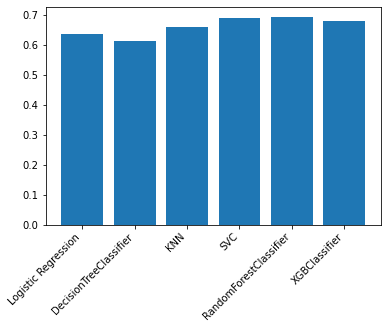

In [207]:
# cross_val_score를 통해 선 비교 - LogisticRegression
# 선언하기
model_lo = LogisticRegression()
# 성능검증
cv_score = cross_val_score(model_lo, x_train_sc, y_train, cv = 10)
# 결과수집
result_cv = {}
result_cv['Logistic Regression'] = cv_score.mean()

# cross_val_score를 통해 선 비교 - DecisionTreeClassifier
# 선언하기
model_dt = DecisionTreeClassifier(random_state=2022)
# 성능검증
cv_score = cross_val_score(model_dt ,x_train, y_train, cv = 10)
# 결과수집
result_cv['DecisionTreeClassifier'] = cv_score.mean()

# cross_val_score를 통해 선 비교 - KNeighborsClassifier
# 선언하기
model_knn = KNeighborsClassifier()
# 성능검증
cv_score = cross_val_score(model_knn ,x_train_sc, y_train, cv = 10)
# 결과수집
result_cv['KNN'] = cv_score.mean()

# cross_val_score를 통해 선 비교 - SVC
# 선언하기
model_svc = SVC(random_state=2022)
# 성능검증
cv_score = cross_val_score(model_svc, x_train_sc, y_train, cv = 10)
# 결과수집
result_cv['SVC'] = cv_score.mean()

# cross_val_score를 통해 선 비교 - RandomForestClassifier
# 선언하기
model_rf = RandomForestClassifier(random_state=2022)
# 성능검증
cv_score = cross_val_score(model_rf, x_train, y_train, cv = 10)
# 결과수집
result_cv['RandomForestClassifier'] = cv_score.mean()

# cross_val_score를 통해 선 비교 - XGBClassifier
# 선언하기
model_xgb = XGBClassifier(random_state=2022, eval_metric = 'mlogloss')
# 성능검증
cv_score = cross_val_score(model_xgb, x_train, y_train, cv = 10)
# 결과수집
result_cv['XGBClassifier'] = cv_score.mean()

# 결과 확인
# cv 값 확인
print('=' * 40)
for m_name, score in result_cv.items():
    print(m_name, score.round(3))
print('=' * 40)

# 시각화
plt.bar(result_cv.keys(), result_cv.values())
plt.xticks(rotation=45, ha='right')
plt.show()

In [208]:
# cv 값을 비교해 본 결과
# => Logistic Regression, RandomForestClassifier, XGBClassifier, SVC 가 성능이 좋게 나옴
# 이 중 RandomForestClassifier, XGBClassifier, SVC 를 모델 튜닝 및 학습으로 결정

#### (1) 알고리즘1

In [209]:
# classification_report 저장 => 검증용
result_cr={}

#classification_report 저장 => 테스트용
result_test ={}

# recall 값만 저장 => 평가지표 비교
result_recall = {}


In [210]:
# RandomForestClassifier 튜닝 및 학습 => 시간 관계상 param을 적게줌
# 선언하기 
model_rf = RandomForestClassifier(random_state=2022)

param = {'max_depth' : range(4,7),
        'n_estimators' : range(260,265)}

model_rf = RandomizedSearchCV(model_rf,
                    param,
                    cv = 5,
                    scoring='accuracy',
                    n_jobs=-1)

In [211]:
# 학습하기
model_rf.fit(x_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2022),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(4, 7),
                                        'n_estimators': range(260, 265)},
                   scoring='accuracy')

In [212]:
# 결과확인
print(model_rf.best_estimator_)
print(model_rf.best_score_)

RandomForestClassifier(max_depth=6, n_estimators=263, random_state=2022)
0.6992499999999999


In [213]:
# 예측하기 => 검증
y_pred = model_rf.predict(x_val)
# 평가하기
print(classification_report(y_val,y_pred))
result_cr['RandomForestClassifier'] = classification_report(y_val,y_pred)

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1520
           1       0.71      0.71      0.71      1480

    accuracy                           0.72      3000
   macro avg       0.72      0.72      0.72      3000
weighted avg       0.72      0.72      0.72      3000



In [214]:
# 예측하기 => 테스트
y_pred = model_rf.predict(x_test)
# 평가하기
print(classification_report(y_test,y_pred))

result_test['RandomForestClassifier'] = classification_report(y_test,y_pred)
result_recall['RandomForestClassifier'] = recall_score(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.70      0.69      0.69      1540
           1       0.68      0.69      0.68      1460

    accuracy                           0.69      3000
   macro avg       0.69      0.69      0.69      3000
weighted avg       0.69      0.69      0.69      3000



#### (2) 알고리즘2

In [215]:
# XGBClassifier 튜닝 및 학습
# 선언하기
model_xgbc = XGBClassifier(random_state = 2022,eval_metric = 'mlogloss' )

param = {'max_depth':range(4,7),
        'n_estimators': range(150,155)}

model_xgb = RandomizedSearchCV(model_xgbc,
                    param,
                    cv = 5,
                    scoring='accuracy',
                    n_jobs=-1)

In [216]:
# 학습하기
model_xgb.fit(x_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                     

In [217]:
# 결과확인
print(model_xgb.best_params_)
print(model_xgb.best_score_)

{'n_estimators': 153, 'max_depth': 4}
0.6940000000000001


In [218]:
# 예측하기 => 검증
y_pred = model_xgb.predict(x_val)
# 평가하기
print(classification_report(y_val,y_pred))
result_cr['XGBClassifier'] = classification_report(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.72      0.68      0.70      1520
           1       0.69      0.73      0.71      1480

    accuracy                           0.71      3000
   macro avg       0.71      0.71      0.71      3000
weighted avg       0.71      0.71      0.71      3000



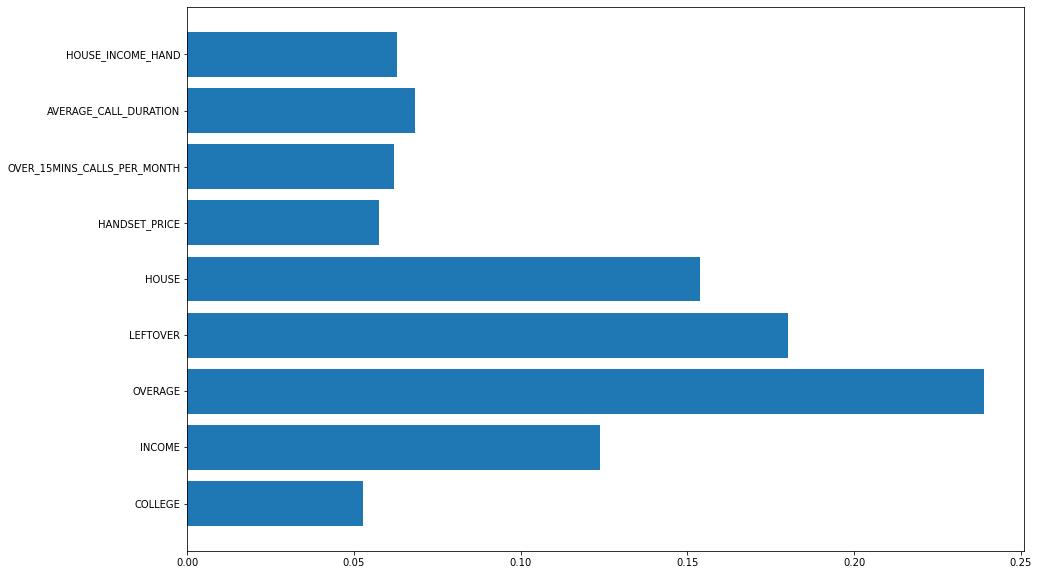

In [219]:
# 중요 변수 확인
plt.figure(figsize=(15,10))
plt.barh(y =list(x) , width = model_xgb.best_estimator_.feature_importances_)
plt.show()

In [220]:
# 예측하기 => 테스트
y_pred = model_xgb.predict(x_test)
# 평가하기
print(classification_report(y_test,y_pred))
result_test['XGBClassifier'] = classification_report(y_test,y_pred)

# recall 값만 저장
result_recall['XGBClassifier'] = recall_score(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.70      0.65      0.68      1540
           1       0.66      0.71      0.68      1460

    accuracy                           0.68      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.68      0.68      0.68      3000



#### (3) 알고리즘3

In [221]:
# SVC 튜닝 및 학습
model_svc = SVC()

param ={'C': np.logspace(-3,3,7),
        'gamma' :np.logspace(-2,1,4)}

m_svm_gs = RandomizedSearchCV(model_svc, param, cv = 5, scoring = 'accuracy', n_jobs=-1)

In [222]:
# 학습하기
m_svm_gs.fit(x_train_sc,y_train)

RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'gamma': array([ 0.01,  0.1 ,  1.  , 10.  ])},
                   scoring='accuracy')

In [223]:
# 결과확인
print(m_svm_gs.best_estimator_)
print(m_svm_gs.best_score_)

SVC(gamma=1.0)
0.6859999999999999


In [224]:
# 예측하기 => 검증
y_pred = m_svm_gs.predict(x_val_sc)
# 평가하기
print(classification_report(y_val,y_pred))
result_cr['SVC'] = classification_report(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.69      0.73      0.71      1520
           1       0.71      0.67      0.69      1480

    accuracy                           0.70      3000
   macro avg       0.70      0.70      0.70      3000
weighted avg       0.70      0.70      0.70      3000



In [225]:
# 예측하기 => 테스트
y_pred = m_svm_gs.predict(x_test_sc)
# 평가하기
print(classification_report(y_test,y_pred))
result_test['SVC'] = classification_report(y_test,y_pred)

# recall 값만 저장
result_recall['SVC'] = recall_score(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.67      0.70      0.69      1540
           1       0.67      0.64      0.66      1460

    accuracy                           0.67      3000
   macro avg       0.67      0.67      0.67      3000
weighted avg       0.67      0.67      0.67      3000



#### (4) 추가

## 4.모델링2 : DL

### 4.1 모델링을 위한 함수 불러오기

In [226]:
# 라이브러리 불러오기
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [227]:
# EarlyStopping 선언
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, restore_best_weights=True)

In [228]:
# input , batch 사이즈 설정 
input = x_train.shape[1]
batch = 128

### 4.2 모델링

* 딥러닝 모델을 3개 이상 생성하시오
    * 다양한 구조의 모델 3개 이상을 설계하시오. (히든레이어, 노드 수 조절)
    * 각 모델은 구조가 달라야 합니다.
    * 구조를 그렇게 구성한 이유를 주석으로 기술해 봅시다.
* 각 모델마다 
    * 구조를 summary 혹은 plot model로 확인
    * 학습 후 history plot 그리고 적절하게 학습이 되었는지 확인    

#### (1) 모델1

In [229]:
# 히든레이어 없이 기본적인 DL모델링

# 세션 초기화
keras.backend.clear_session()

#레이어 연결
il = keras.layers.Input(shape=(input,))
ol = keras.layers.Dense(1, activation='sigmoid')(il)

# 모델 시작과 끝 지정
model_dl_basic = keras.models.Model(il,ol)

#컴파일
model_dl_basic.compile(loss = 'binary_crossentropy', optimizer='adam', metrics='accuracy')

#요약
model_dl_basic.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense (Dense)               (None, 1)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [123]:
history = model_dl_basic.fit(x_train_sc, y_train, epochs=2000, verbose=1, validation_split=0.2, callbacks=[es], batch_size=batch )

Epoch 1/2000
75/75 [==============================] - 1s 4ms/step - loss: 0.6992 - accuracy: 0.5115 - val_loss: 0.6871 - val_accuracy: 0.5379
Epoch 2/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6780 - accuracy: 0.5579 - val_loss: 0.6736 - val_accuracy: 0.5713
Epoch 3/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6694 - accuracy: 0.5917 - val_loss: 0.6676 - val_accuracy: 0.5971
Epoch 4/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6648 - accuracy: 0.6095 - val_loss: 0.6638 - val_accuracy: 0.6108
Epoch 5/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6612 - accuracy: 0.6160 - val_loss: 0.6607 - val_accuracy: 0.6204
Epoch 6/2000
75/75 [==============================] - 0s 3ms/step - loss: 0.6581 - accuracy: 0.6186 - val_loss: 0.6581 - val_accuracy: 0.6212
Epoch 7/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6553 - accuracy: 0.6206 - val_loss: 0.6559 - val_accuracy: 0.6208
Epoch 

75/75 [==============================] - 0s 2ms/step - loss: 0.6314 - accuracy: 0.6404 - val_loss: 0.6416 - val_accuracy: 0.6212
Epoch 116/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6314 - accuracy: 0.6409 - val_loss: 0.6416 - val_accuracy: 0.6225
Epoch 117/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6314 - accuracy: 0.6411 - val_loss: 0.6416 - val_accuracy: 0.6208
Epoch 118/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6314 - accuracy: 0.6402 - val_loss: 0.6415 - val_accuracy: 0.6212
Epoch 119/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6314 - accuracy: 0.6413 - val_loss: 0.6416 - val_accuracy: 0.6212
Epoch 120/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6314 - accuracy: 0.6407 - val_loss: 0.6416 - val_accuracy: 0.6212
Epoch 121/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6314 - accuracy: 0.6411 - val_loss: 0.6416 - val_accuracy: 0.6208
Epoch 1

Epoch 172/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6313 - accuracy: 0.6398 - val_loss: 0.6414 - val_accuracy: 0.6242
Epoch 173/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6313 - accuracy: 0.6410 - val_loss: 0.6414 - val_accuracy: 0.6242
Epoch 174/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6313 - accuracy: 0.6411 - val_loss: 0.6415 - val_accuracy: 0.6229
Epoch 175/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6313 - accuracy: 0.6402 - val_loss: 0.6414 - val_accuracy: 0.6237
Epoch 176/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6313 - accuracy: 0.6410 - val_loss: 0.6414 - val_accuracy: 0.6242
Epoch 177/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6313 - accuracy: 0.6415 - val_loss: 0.6414 - val_accuracy: 0.6237
Epoch 178/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6313 - accuracy: 0.6405 - val_loss: 0.6414 - val_accuracy:

Epoch 229/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6313 - accuracy: 0.6414 - val_loss: 0.6414 - val_accuracy: 0.6242
Epoch 230/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6313 - accuracy: 0.6419 - val_loss: 0.6414 - val_accuracy: 0.6242
Epoch 231/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6313 - accuracy: 0.6415 - val_loss: 0.6414 - val_accuracy: 0.6233
Epoch 232/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6313 - accuracy: 0.6416 - val_loss: 0.6414 - val_accuracy: 0.6225
Epoch 233/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6313 - accuracy: 0.6417 - val_loss: 0.6414 - val_accuracy: 0.6229
Epoch 234/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6313 - accuracy: 0.6421 - val_loss: 0.6414 - val_accuracy: 0.6221
Epoch 235/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6313 - accuracy: 0.6411 - val_loss: 0.6414 - val_accuracy:

In [230]:
# 예측하기 => 검증
y_pred = model_dl_basic.predict(x_val_sc)
preds_1d = y_pred.flatten() # 차원 펴주기
pred_class = np.where(preds_1d > 0.5, 1 , 0) #0.5보다크면 2, 작으면 1
# 평가하기
print(classification_report(y_val,pred_class))
result_cr['dl_basic'] = classification_report(y_val, pred_class)



              precision    recall  f1-score   support

           0       0.50      0.71      0.59      1520
           1       0.49      0.29      0.36      1480

    accuracy                           0.50      3000
   macro avg       0.50      0.50      0.48      3000
weighted avg       0.50      0.50      0.48      3000



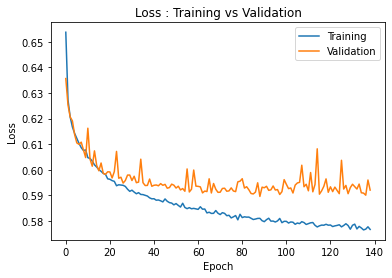

In [231]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

In [232]:
# epoch20을 기점으로 과적합이 발생 할 여지가 보임

In [233]:
# 예측하기 => 테스트
y_pred = model_dl_basic.predict(x_test_sc)
preds_1d = y_pred.flatten() # 차원 펴주기
pred_class = np.where(preds_1d > 0.5, 1 , 0) #0.5보다크면 2, 작으면 1
# 평가하기
print(classification_report(y_test,pred_class))
result_test['dl_basic'] = classification_report(y_test, pred_class)

# recall 값만 저장
result_recall['dl_basic'] = recall_score(y_test,pred_class)

              precision    recall  f1-score   support

           0       0.51      0.70      0.59      1540
           1       0.47      0.28      0.35      1460

    accuracy                           0.49      3000
   macro avg       0.49      0.49      0.47      3000
weighted avg       0.49      0.49      0.47      3000



#### (2) 모델2

In [234]:
# 히든레이어 추가 => 숨겨진 레이어를 찾기 위해 , 좀 더 복잡하게 모델을 구성

# 세션 초기화
keras.backend.clear_session()

#레이어 연결
il = keras.layers.Input(shape=(input,))
hl = keras.layers.Dense(64, activation = 'relu')(il)
hl = keras.layers.Dense(32, activation = 'relu')(hl)
hl = keras.layers.Dense(16, activation = 'relu')(hl)
hl = keras.layers.Dense(8, activation = 'relu')(hl)
ol = keras.layers.Dense(1, activation='sigmoid')(hl)

# 모델 시작과 끝 지정
model_dl_hidden = keras.models.Model(il,ol)

#컴파일
model_dl_hidden.compile(loss = 'binary_crossentropy', optimizer='adam', metrics='accuracy')

#요약
model_dl_hidden.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable par

In [235]:
history = model_dl_hidden.fit(x_train_sc, y_train, epochs=2000, verbose=1, validation_split=0.2, callbacks=[es], batch_size=batch )

Epoch 1/2000
75/75 [==============================] - 1s 4ms/step - loss: 0.6591 - accuracy: 0.6212 - val_loss: 0.6359 - val_accuracy: 0.6392
Epoch 2/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6210 - accuracy: 0.6604 - val_loss: 0.6220 - val_accuracy: 0.6533
Epoch 3/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6130 - accuracy: 0.6648 - val_loss: 0.6185 - val_accuracy: 0.6637
Epoch 4/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6092 - accuracy: 0.6709 - val_loss: 0.6119 - val_accuracy: 0.6737
Epoch 5/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6071 - accuracy: 0.6727 - val_loss: 0.6119 - val_accuracy: 0.6692
Epoch 6/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6045 - accuracy: 0.6752 - val_loss: 0.6092 - val_accuracy: 0.6754
Epoch 7/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.6034 - accuracy: 0.6757 - val_loss: 0.6083 - val_accuracy: 0.6767
Epoch 

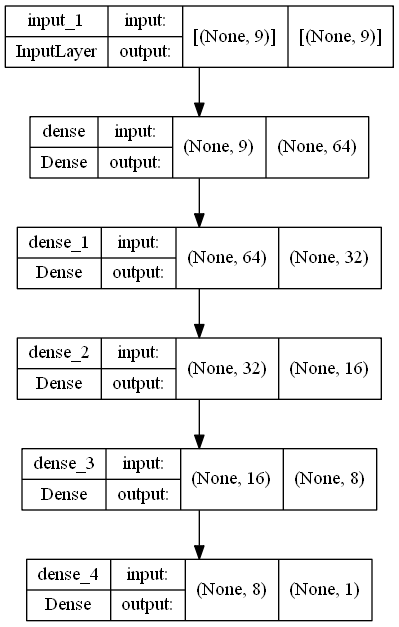

In [260]:
plot_model(model_dl_hidden , show_shapes=True)

In [236]:
# 예측하기 => 검증
y_pred = model_dl_hidden.predict(x_val_sc)
preds_1d = y_pred.flatten() # 차원 펴주기
pred_class = np.where(preds_1d > 0.5, 1 , 0) #0.5보다크면 2, 작으면 1
# 평가하기
print(classification_report(y_val,pred_class))
result_cr['dl_hidden'] = classification_report(y_val, pred_class)

              precision    recall  f1-score   support

           0       0.71      0.68      0.69      1520
           1       0.68      0.72      0.70      1480

    accuracy                           0.70      3000
   macro avg       0.70      0.70      0.70      3000
weighted avg       0.70      0.70      0.70      3000



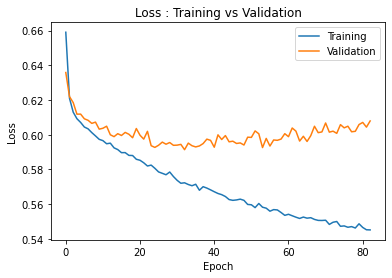

In [237]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

In [238]:
# 끝으로 갈 수록 과적합을 보이고 있음.

In [239]:
# 예측하기 => 테스트
y_pred = model_dl_hidden.predict(x_test_sc)
preds_1d = y_pred.flatten() # 차원 펴주기
pred_class = np.where(preds_1d > 0.5, 1 , 0) #0.5보다크면 2, 작으면 1
# 평가하기
print(classification_report(y_test,pred_class))
result_test['dl_hidden'] = classification_report(y_test, pred_class)

# recall 값만 저장
result_recall['dl_hidden'] = recall_score(y_test,pred_class)

              precision    recall  f1-score   support

           0       0.70      0.65      0.67      1540
           1       0.66      0.70      0.68      1460

    accuracy                           0.68      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.68      0.68      0.68      3000



#### (3) 모델3

In [240]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   COLLEGE                      18000 non-null  int64  
 1   INCOME                       18000 non-null  int64  
 2   OVERAGE                      18000 non-null  int64  
 3   LEFTOVER                     18000 non-null  int64  
 4   HOUSE                        18000 non-null  float64
 5   HANDSET_PRICE                18000 non-null  int64  
 6   OVER_15MINS_CALLS_PER_MONTH  18000 non-null  int64  
 7   AVERAGE_CALL_DURATION        18000 non-null  int64  
 8   HOUSE_INCOME_HAND            18000 non-null  float64
dtypes: float64(2), int64(7)
memory usage: 1.2 MB


###  add를 이용해 비슷한 그룹 별로 딥러닝
* 재산인 부분과 그것이 아닌 부분 두 그룹으로 나누어서 레이어를 add
* 이탈이 재산과 관련이 있을 것이라고 생각해서 관련있는 그룹과 없는 그룹으로 나누어서 새로운 레이어를 만듬
* 재산 : INCOME, HOUSE, HANDSET_PRICE, HOUSE_INCOME_HAND
* 그 외: COLLEGE, OVERAGE, LEFTOVER, OVER_15MINS_CALLS_PER_MONTH, AVERAGE_CALL_DURATION

In [241]:
# 데이터 구분 

In [242]:
df_x_money = x_train_sc.loc[:,['INCOME','HOUSE', 'HANDSET_PRICE', 'HOUSE_INCOME_HAND']]
df_x_etc = x_train_sc.loc[:,['COLLEGE','OVERAGE', 'LEFTOVER', 'OVER_15MINS_CALLS_PER_MONTH', 'AVERAGE_CALL_DURATION']]

In [243]:
val_x_money = x_val_sc.loc[:,['INCOME','HOUSE', 'HANDSET_PRICE', 'HOUSE_INCOME_HAND']]
val_x_etc = x_val_sc.loc[:,['COLLEGE','OVERAGE', 'LEFTOVER', 'OVER_15MINS_CALLS_PER_MONTH', 'AVERAGE_CALL_DURATION']]

In [244]:
te_x_money = x_test_sc.loc[:,['INCOME','HOUSE', 'HANDSET_PRICE', 'HOUSE_INCOME_HAND']]
te_x_etc = x_test_sc.loc[:,['COLLEGE','OVERAGE', 'LEFTOVER', 'OVER_15MINS_CALLS_PER_MONTH', 'AVERAGE_CALL_DURATION']]

In [245]:
df_x_money.shape ,df_x_etc.shape

((12000, 4), (12000, 5))

In [246]:
# add + hidden
# 세션 초기화
keras.backend.clear_session()

#레이어 연결
il_s = keras.layers.Input(shape=(4,))
hl_s = keras.layers.Dense(32, activation ='relu')(il_s)
hl_s = keras.layers.Dense(16, activation ='relu')(hl_s)

il_p = keras.layers.Input(shape=(5,))
hl_p = keras.layers.Dense(32,activation ='relu')(il_p)
hl_p = keras.layers.Dense(16, activation ='relu')(hl_p)

ad = keras.layers.Add()([hl_s, hl_p])
ol = keras.layers.Dense(1, activation='sigmoid')(ad)

# 모델 시작과 끝 지정
model_hl_add = keras.models.Model([il_s, il_p], ol)

#컴파일
model_hl_add.compile(loss = 'binary_crossentropy', optimizer='adam', metrics='accuracy')

model_hl_add.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           160         ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 32)           192         ['input_2[0][0]']                
                                                                                              

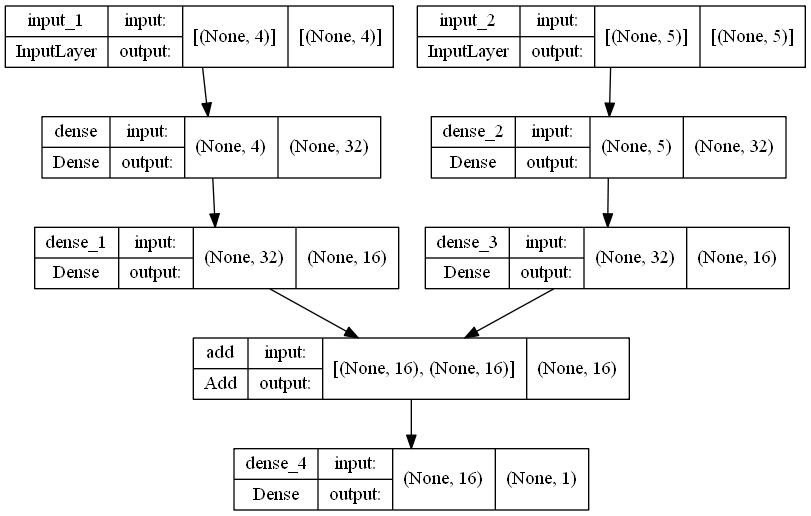

In [247]:
plot_model(model_hl_add , show_shapes=True)

In [248]:
# 학습
history = model_hl_add.fit([df_x_money, df_x_etc], y_train, epochs=1000, verbose=1, callbacks=[es], validation_split=0.15)

Epoch 1/1000
319/319 [==============================] - 1s 2ms/step - loss: 0.6483 - accuracy: 0.6299 - val_loss: 0.6340 - val_accuracy: 0.6261
Epoch 2/1000
319/319 [==============================] - 1s 2ms/step - loss: 0.6251 - accuracy: 0.6549 - val_loss: 0.6252 - val_accuracy: 0.6506
Epoch 3/1000
319/319 [==============================] - 1s 2ms/step - loss: 0.6192 - accuracy: 0.6603 - val_loss: 0.6199 - val_accuracy: 0.6606
Epoch 4/1000
319/319 [==============================] - 1s 2ms/step - loss: 0.6159 - accuracy: 0.6634 - val_loss: 0.6154 - val_accuracy: 0.6639
Epoch 5/1000
319/319 [==============================] - 1s 2ms/step - loss: 0.6128 - accuracy: 0.6686 - val_loss: 0.6122 - val_accuracy: 0.6728
Epoch 6/1000
319/319 [==============================] - 1s 2ms/step - loss: 0.6101 - accuracy: 0.6720 - val_loss: 0.6145 - val_accuracy: 0.6606
Epoch 7/1000
319/319 [==============================] - 1s 2ms/step - loss: 0.6081 - accuracy: 0.6725 - val_loss: 0.6072 - val_accuracy:

319/319 [==============================] - 1s 2ms/step - loss: 0.5760 - accuracy: 0.7034 - val_loss: 0.5883 - val_accuracy: 0.6928
Epoch 114/1000
319/319 [==============================] - 1s 2ms/step - loss: 0.5744 - accuracy: 0.7021 - val_loss: 0.5873 - val_accuracy: 0.6889
Epoch 115/1000
319/319 [==============================] - 1s 2ms/step - loss: 0.5749 - accuracy: 0.7049 - val_loss: 0.5871 - val_accuracy: 0.6900
Epoch 116/1000
319/319 [==============================] - 1s 2ms/step - loss: 0.5758 - accuracy: 0.7015 - val_loss: 0.5891 - val_accuracy: 0.6861
Epoch 117/1000
319/319 [==============================] - 1s 2ms/step - loss: 0.5745 - accuracy: 0.7001 - val_loss: 0.5857 - val_accuracy: 0.6950
Epoch 118/1000
319/319 [==============================] - 1s 2ms/step - loss: 0.5753 - accuracy: 0.7023 - val_loss: 0.5858 - val_accuracy: 0.6928
Epoch 119/1000
319/319 [==============================] - 1s 2ms/step - loss: 0.5754 - accuracy: 0.7031 - val_loss: 0.5885 - val_accuracy: 

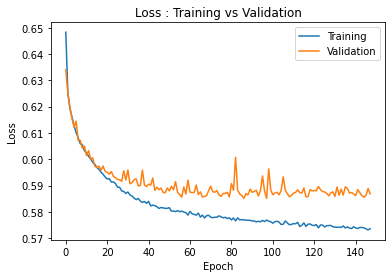

In [249]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

In [250]:
# 3개의 딥러닝 모델 중 비교적 좋은 그래프를 보이고 있음
# epoch20을 기점으로 과적합이 발생 할 여지가 보임

In [251]:
# 예측하기 => 검증
y_pred = model_hl_add.predict([val_x_money, val_x_etc])
preds_1d = y_pred.flatten() # 차원 펴주기
pred_class = np.where(preds_1d > 0.5, 1 , 0) #0.5보다크면 2, 작으면 1
# 평가하기
print(classification_report(y_val,pred_class))
result_cr['dl_add'] = classification_report(y_val, pred_class)

              precision    recall  f1-score   support

           0       0.75      0.63      0.69      1520
           1       0.68      0.78      0.72      1480

    accuracy                           0.71      3000
   macro avg       0.71      0.71      0.71      3000
weighted avg       0.71      0.71      0.71      3000



In [252]:
# 예측하기 => 테스트
y_pred = model_hl_add.predict([te_x_money, te_x_etc])
preds_1d = y_pred.flatten() # 차원 펴주기
pred_class = np.where(preds_1d > 0.5, 1 , 0) #0.5보다크면 2, 작으면 1
# 평가하기
print(classification_report(y_test,pred_class))
result_test['dl_add'] = classification_report(y_test, pred_class)

# recall 값만 저장
result_recall['dl_add'] = recall_score(y_test,pred_class)

              precision    recall  f1-score   support

           0       0.73      0.60      0.66      1540
           1       0.64      0.76      0.70      1460

    accuracy                           0.68      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.69      0.68      0.68      3000



#### (4) 추가

## 5.성능 비교
* 총 모델이 최소한 ML 3가지, DL 3가지 입니다. 이에 대해 성능을 평가합니다.
* 평가를 위한 적절한 지표(metric)을 결정하고 비교합니다.
    * **평가지표 선정 이유**를 주석으로 기술하시오.
* 최종 모델을 **선정하게 된 근거**를 주석으로 기술하시오.

In [253]:
# 성능비교 한 모델
# ML : RandomForestClassifier , XGBClassifier, SVC
# DL : dl_basic, dl_hidden, dl_add

### 5.1 평가지표 결정

* 어떤 지표로 성능을 비교할지 결정합니다.
* 결정 이유를 기술합니다.

In [254]:
# 검증용 데이터 성능 비교
for i, j in result_cr.items():
    print('='*54)
    print(i)
    print('-'*54)
    print(j)

RandomForestClassifier
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1520
           1       0.71      0.71      0.71      1480

    accuracy                           0.72      3000
   macro avg       0.72      0.72      0.72      3000
weighted avg       0.72      0.72      0.72      3000

XGBClassifier
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      1520
           1       0.69      0.73      0.71      1480

    accuracy                           0.71      3000
   macro avg       0.71      0.71      0.71      3000
weighted avg       0.71      0.71      0.71      3000

SVC
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.73      0.71      1520
           1       0.71      0.

In [255]:
# 테스트 데이터 성능 비교
for i, j in result_test.items():
    print('='*54)
    print(i)
    print('-'*54)
    print(j)

RandomForestClassifier
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      1540
           1       0.68      0.69      0.68      1460

    accuracy                           0.69      3000
   macro avg       0.69      0.69      0.69      3000
weighted avg       0.69      0.69      0.69      3000

XGBClassifier
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.65      0.68      1540
           1       0.66      0.71      0.68      1460

    accuracy                           0.68      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.68      0.68      0.68      3000

SVC
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.70      0.69      1540
           1       0.67      0.

### 평가지표 : recall
*  근거 : 현재 우리 회사의 목표는 현재 고객수를 유지하는 것이다 그러므로 약정기간이 끝나 이탈할 것이라는 고객을 잡아 새로운 인사이트를 이용해 고객을 잡아야한다. recall은 실제 이탈 할 것이라고 하는 사람중에서 모델이 이탈할 것이라고 예측한 비율이기 때문에 가장 적합하다고 생각한다.

### 5.2 성능 비교

* 성능을 비교하고, 최적의 모델을 선정하시오.
* 선정 근거를 주석으로 기술하시오.

In [256]:
# test recall 값 확인 및 비교
print('=' * 40)
for m_name, score in result_recall.items():
    print(m_name, score.round(3))
print('=' * 40)

RandomForestClassifier 0.686
XGBClassifier 0.708
SVC 0.642
dl_basic 0.281
dl_hidden 0.701
dl_add 0.76


### 최적의 모델 : DL
* 근거 : recall의 성능을 비교해 봤을 때 , 변수를 두 그룹으로 묶고 그것을 add해서 한 딥러닝의 결과가 가장 높게 나왔다. 이탈 할 고객들의 재산이 많으면 생각 부담이 덜 커서 쉽게 이탈 할 것이라는 가설이 조금은 맞다고 생각됐다. 머신러닝에 비해 히든레이어를 추가한 딥러닝 쪽 성능이 좋게 나왔고, 우리가 모르는 레이어, 변수 들의 관계가 있다고 생각한다. 각 변수들의 관계를 더 파악하고 좀 더 깊은 딥러닝을 사용한다면 모델 중 가장 좋게 나올 수 있다고 생각해서 딥러닝을 최적의 모델로 선택했다.

### 5.3 추가 분석 및 의견

* 성능을 한눈에 비교할 수 있는 방법을 고안해서 수행해 봅시다.

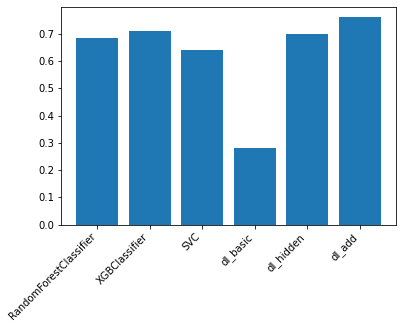

In [257]:
# recall 의 평가지표를 시각화해서 어떤 모델의 성능이 좋은지 한 눈에 볼 수 있다.
# 시각화
plt.bar(result_recall.keys(), result_recall.values())
plt.xticks(rotation=45, ha='right')
plt.show()

* 여러분의 선정한 모델로 비즈니스 문제를 해결할 수 있을까요? 여러분의 의견을 적어 봅시다.

### 분석결과
* 처음 eda 분석 결과 소득이 높은 사람들 중에서 66.5% 정도가 통화 시간량이 높았고, 그렇다면 초과 통화시간 또한 많을 것이다. 이것을 딥러닝 모델에 적용하고 싶어서 소득을 관련해서 두 그룹으로 나누고 모델 성능을 평가 해 본 결과 성능이 가장 좋게 나왔다.
* 그러므로 평균 수입이 높은 사람들을 잡기 위해서 혜택이나 서비스등을 생각해 볼 수 있고, 다양한 해결책들을 뽑아 내 이탈자를 막아낸다면 문제를 해결할 수 있을 것이다.

* 비즈니스 문제 해결을 위해서 더 해볼 수 있는 것은 무엇인가요?

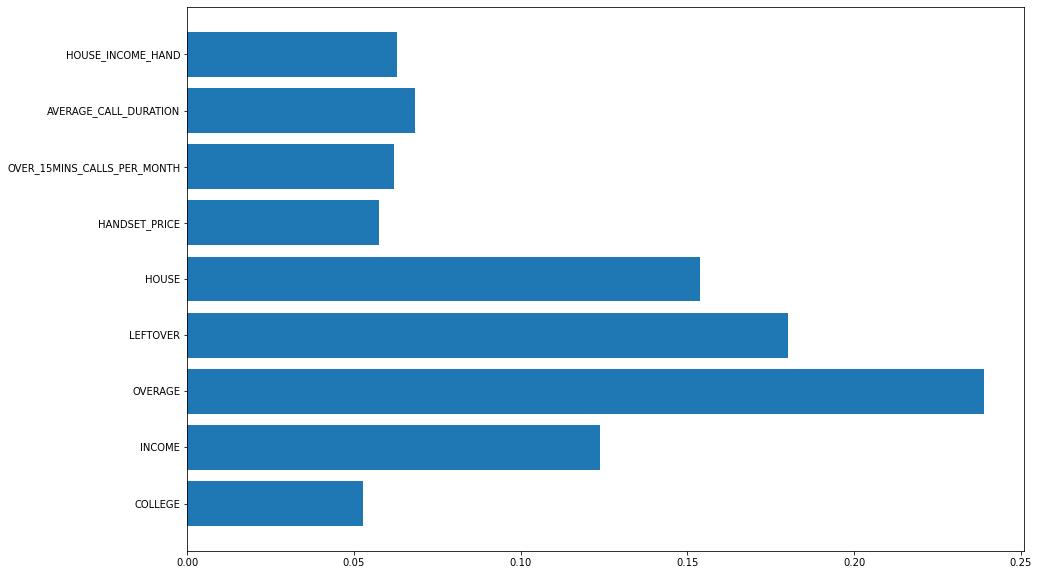

In [258]:
# 중요 변수 확인
plt.figure(figsize=(15,10))
plt.barh(y =list(x) , width = model_xgb.best_estimator_.feature_importances_)
plt.show()

### 추가분석
* 위에서 확인했던 xgb의 중요 변수를 시각화 한 그래프이다.
* xgb 또한 머신러닝 중 좋은 성능을 보였기 때문에 튜닝을 통해 더 좋은 성능을 보일 수 있을 것이다.
* 여기서 보면 OVERAGE, LEFTOVER, HOUSE, INCOME 네가지의 변수가 성능을 판단하는데 가장 중요하게 나왔다
* 위에서 분석 했던 것과 같이 재산, 초과시간이 이탈률에 크게 영향이 있다는 것을 다시한번 알 수 있다.
* 그와 다르게 LEFTOVER(월 사용 잔여시간) 또한 중요한 변수인데 eda 분석 결과, 남은 시간이 25%이상인 사람들이 이탈률이 높은 것으로 확인이 된다. 그러므로 해당 고객을 대상으로 서비스를 제공 할 필요가 있다.

### 비즈니스 인사이트

* 불 필요했던 설문 결과를 좀 더 신뢰성이 있는 데이터로 만들 필요가 있습니다.
* 재산이 많은 고객층인 프리미엄 고객들에게 타 통신사보다 만족 할 수 있는 서비스를 제공해야 할 것입니다.
* 통화 초과 사용시간이 넘어간 고객들에게 더 많은 서비스를 제공해야 할 것입니다.
* 재산과 통화 시간이 관련이 있다고 생각하는데 통화에 대한 품질이 마음에 안 들어 쉽게 이탈 하는 것으로 보입니다.
* 고객들을 세분화해서 그룹화 하여 맞춤형 혜택을 제공 하는 것이 좋아보입니다.